# Tarea 1

## Analisis estadistico de comentarios de Youtube primer debate presidencial

In [3]:
#para poder instalar la API para descargar los commentarios de Youtube
#!pip install youtube-comment-downloader
#!pip install pandas as pd
#!pip install numpy as np
#!pip install textblob

Importamos los comentarios de Youtube directamente del video de interes, obteniendo la siguiente información Comentario_ID = cid, Comentario = text, Temporalidad del comentario = time, Nombre de usuario del comentador = author, Canal de comunicacion = channel, Numero de votos del comentario = votes, Numero de replicas del comentario = replies, imagen de perfil del usuario (URL) = photo, comment['heart'], comment['reply'], comment['time_parsed']

In [30]:
import csv
from itertools import islice
from youtube_comment_downloader import *

downloader = YoutubeCommentDownloader()
comments = downloader.get_comments_from_url('https://www.youtube.com/watch?v=kZaucITWv00&t=10s', sort_by=SORT_BY_POPULAR)

# Abre un archivo CSV en modo escritura
with open('comentarios.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["cid", "text", "time", "author", "channel", "votes", "replies", "photo", "heart", "reply", "time_parsed"])
    for comment in islice(comments, 4307): #4307
        writer.writerow([comment['cid'], comment['text'], comment['time'], comment['author'], comment['channel'], comment['votes'], comment['replies'], comment['photo'], comment['heart'], comment['reply'], comment['time_parsed']])

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split


In [144]:
df = pd.read_csv('comentarios.csv')

## Iniciamos preparando los datos que emplearemos para la estadistica ademas del texto

### pre procesado de datos

Adecaucuacion de la columna de votos, se combierten los valores no numericos a valores numericos

In [145]:
df['new_column'] = 1
df.loc[df['votes'].str.contains('K'), 'new_column'] = 1000
df['votes'] = df['votes'].str.replace('K', '')
df['votes'] = df['votes'].astype(float)
df['votes'] = df['votes'] * df['new_column']
df.drop(columns=['new_column'], inplace=True)
df['votes'] = df['votes'].replace(0, np.nan)
df['votes'] = df['votes'].replace(' ', np.nan)

In [146]:
from textblob import TextBlob

In [147]:
#  Para traducir comentarios en ingles
"""from textblob import TextBlob
df['textEs']=df['text'].apply(lambda x: TextBlob(x).translate(to='es'))
print(df['textEs'].head(9))
"""

"from textblob import TextBlob\ndf['textEs']=df['text'].apply(lambda x: TextBlob(x).translate(to='es'))\nprint(df['textEs'].head(9))\n"

In [148]:
df['polaridad']=df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subobj']=df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity) 
print(df['polaridad'].describe())
print(df['subobj'].describe())

count    1970.000000
mean       -0.001623
std         0.094901
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: polaridad, dtype: float64
count    1970.000000
mean        0.035070
std         0.163839
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: subobj, dtype: float64


C:\Users\juanj\AppData\Local\Temp\ipykernel_14056\829880397.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-1, 10000)


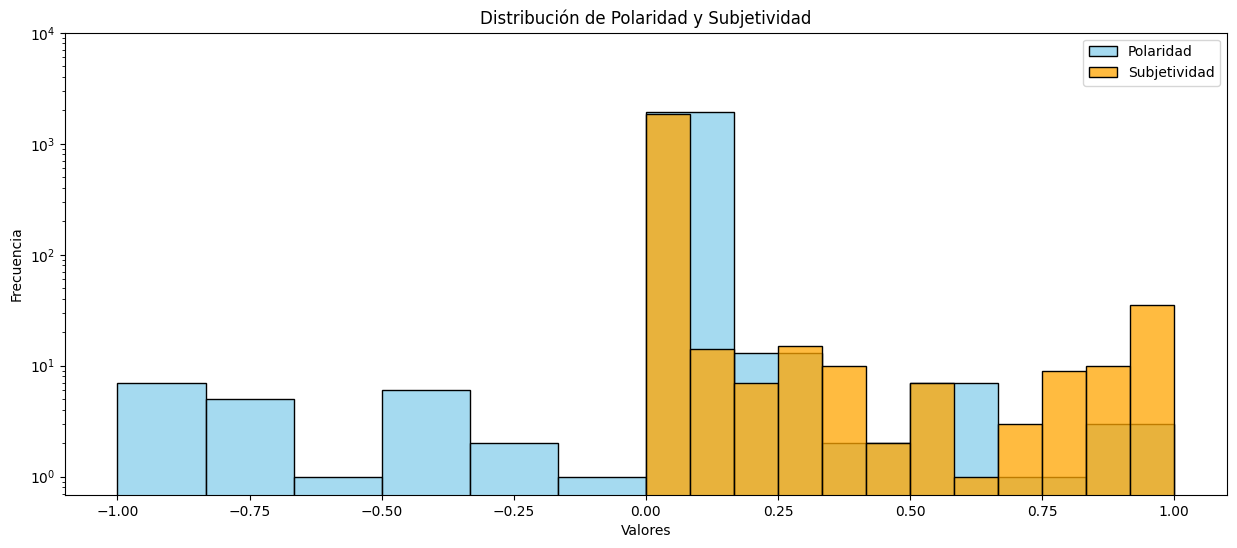

In [191]:
plt.figure(figsize=(15, 6))

sns.histplot(df['polaridad'], color='skyblue', label='Polaridad')
sns.histplot(df['subobj'], color='orange', label='Subjetividad')

plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.title('Distribución de Polaridad y Subjetividad de los comentarios')
plt.legend()
plt.ylim(-1, 10000)
plt.show()

## realizamos la identificacion y preparacion del procesado del Texto

In [121]:
df['text'] = df['text'].astype(str)
ComYT = df['text']
ComYT[0:10]

0    Yo en la vida soy Maynez siempre sonriendo aun...
1    Me uno a exigir que pongan los relojes de los ...
2    Me parece muy bien cómo contestó Maynes, fue d...
3    Jajaja cuando le marcaron más tiempo para Xóch...
4    Cómo lo supuse , Xóchitl solo se dedicó a atac...
5    Maynez por lo menos estaba mas preparado que x...
6    Lo que queremos los mexicanos son propuestas, ...
7    Sueño con un debate presidencial en donde todo...
8    El reloj debió verse en todo momento, para ten...
9    21:19  "es muy impogtante preguntarle a las pe...
Name: text, dtype: object

In [122]:
# Supongamos que df['text'] es tu Serie de pandas con los párrafos
ComYT = df['text'].astype(str)

# Inicializa una cadena vacía para almacenar todo el texto
ComYTcom = ''

for parrafo in ComYT:
    ComYTcom += parrafo + '\r'

print(ComYTcom)
print(type(ComYTcom))

Me parece muy bien cómo contestó Maynes, fue directo a sus preguntas empo. Debería haber más transparencia.
21:19  "es muy impogtante preguntarle a las personas que murieron" conteo del tiempoción a elegir para atacarse entre ustedes.bar” Denis no aguantó la risa jajajajajajajaja
Preguntarle a los que Murieron?????a cubeta, eso queríamos ver. Hasta que alguien llorara 😂😂😂😂😂só Claudiaás. PRIAN, corruptos, el PASADO, Neoliberallos apoye.aba usando la cabeza? porque sinceramente ahi no apreciera, mostro inmadurez, no llevaba pruebas solidas ni nada por el estilo, solo llevaba fotos o carteles pero no es una prueba solida como tal, la xochilt muy inmadura para sus ataques y realmente pudo causar admiracion si atacara pero supiera escuchar para no decir incoherenciasropia cuenta para manejar algo tan simple sin depender de otros para manejar el paíse serán menos capaces siendo el manejo de tiempo la clave...
Te parece?ja pero también pasaba igual a los que solían ser oposición xD jajajajaja

In [123]:
ComYT_sp = ComYTcom.split("\n")
ComYT_sp[:20]

['Yo en la vida soy Maynez siempre sonriendo aunque me esté llevando la vrg😂\rMe uno a exigir que pongan los relojes de los 3 canditatos todo el tiempo. Debería haber más transparencia.\rMe parece muy bien cómo contestó Maynes, fue directo a sus preguntas ',
 'Xochitl contestaba todo menos las preguntas\rJajaja cuando le marcaron más tiempo para Xóchitl del que realmente tenía. Claudia dijo “hasta la bolsa de tiempo se quiere robar” Denis no aguantó la risa jajajajajajajaja\rCómo lo supuse , Xóchitl solo se dedicó a atacar a Claudia en vez de dar propuestas 🙄🙄🙄 Maynez estuvo más neutro .\rMaynez por lo menos estaba mas preparado que xochilt\rLo que queremos los mexicanos son propuestas, soluciones. Estamos artos de que usen sus 5 minutos para atacarse entre ustedes.\rSueño con un debate presidencial en donde todos los candidatos sean una potencial opción a elegir\rEl reloj debió verse en todo momento, para tener transparencia del conteo del tiempo\r21:19  "es muy impogtante preguntarle

In [124]:
ComYT_filtrado1 = list(filter(None, ComYT_sp))
ComYT_filtrado1[:20]

['Yo en la vida soy Maynez siempre sonriendo aunque me esté llevando la vrg😂\rMe uno a exigir que pongan los relojes de los 3 canditatos todo el tiempo. Debería haber más transparencia.\rMe parece muy bien cómo contestó Maynes, fue directo a sus preguntas ',
 'Xochitl contestaba todo menos las preguntas\rJajaja cuando le marcaron más tiempo para Xóchitl del que realmente tenía. Claudia dijo “hasta la bolsa de tiempo se quiere robar” Denis no aguantó la risa jajajajajajajaja\rCómo lo supuse , Xóchitl solo se dedicó a atacar a Claudia en vez de dar propuestas 🙄🙄🙄 Maynez estuvo más neutro .\rMaynez por lo menos estaba mas preparado que xochilt\rLo que queremos los mexicanos son propuestas, soluciones. Estamos artos de que usen sus 5 minutos para atacarse entre ustedes.\rSueño con un debate presidencial en donde todos los candidatos sean una potencial opción a elegir\rEl reloj debió verse en todo momento, para tener transparencia del conteo del tiempo\r21:19  "es muy impogtante preguntarle

## AQUI inica el procesamiento del texto

importamos las librerias que vamos a utilizar

In [125]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Importamos el TXT y empezamos

In [126]:
def eliminar_emojis(texto):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticones
                           u"\U0001F300-\U0001F5FF"  # símbolos & pictogramas
                           u"\U0001F680-\U0001F6FF"  # transporte & símbolos de mapas
                           u"\U0001F1E0-\U0001F1FF"  # banderas (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', texto)


In [127]:
#def tokens(txt):
#    ComYT_limpio = eliminar_emojis(txt)
#    ComYT_limpio = re.sub(r'[^\w\s]', '', txt.lower())
#
#    stop_words = set(stopwords.words('spanish'))## filtramos stordswords
#    tokens = word_tokenize(ComYT_limpio)
#
#    stemmer = SnowballStemmer('spanish') # filtrado de Stemmer /desidencia
#    ComYT_filtrado = [stemmer.stem(word) for word in tokens if word not in stop_words]
#    return ComYT_filtrado

In [128]:
def tokens(txt):
    ComYT_limpio = eliminar_emojis(txt)
    ComYT_limpio = re.sub(r'[^\w\s]', '', txt.lower())

    stop_words = set(stopwords.words('spanish'))## filtramos stordswords
    tokens = word_tokenize(ComYT_limpio)

    stemmer = SnowballStemmer('spanish') # filtrado de Stemmer /desidencia
    ComYT_filtrado = [stemmer.stem(word) for word in tokens if word not in stop_words]
    ComYT_filtrado = [word for word in tokens if word not in stop_words]
    return ComYT_filtrado

In [129]:
map(tokens, ComYT_filtrado1)
map

map

In [130]:
map_ComYT = list(map(tokens, ComYT_filtrado1))

In [131]:
map_ComYT[151:300]

[['sospechosa',
  'actitud',
  'chochil',
  'debería',
  'ver',
  'países',
  'hacen',
  'depremir',
  'estudiantes',
  'tantas',
  'horas',
  'clases',
  'salen',
  'vacaciones',
  'dejan',
  'tantas',
  'tareas',
  'solo',
  'estresan',
  'sheinbaum',
  'nunca',
  'aclaró',
  'ivermectina',
  'perdono',
  'doctora',
  'deje',
  'decir',
  'sé',
  'científica',
  'jajajajaja',
  'xd',
  'claudia',
  '100tifica',
  'peña',
  'bastante',
  'vergüenza',
  'representar',
  'país',
  'xóchitl',
  'payasada',
  'si',
  'votamos',
  'maynez',
  'vemos',
  'si',
  'verdad',
  'democracia',
  'parece',
  'mas',
  'honesta',
  'xochitl',
  'claudia',
  'maines',
  'parece',
  'bueno',
  'discurso',
  'sabemos',
  'llevando',
  'agua',
  'molino',
  'claudia',
  'cochitl',
  'puede',
  'repetir',
  'pregunta'],
 ['caras',
  'perdedora',
  'tan',
  'divertidas',
  'mano',
  'dura',
  'reloj',
  'siempre',
  'favor',
  'xochitl',
  'nadie'],
 ['xochitl',
  'gobiegggno',
  'cogggupsion',
  'infraes

In [132]:
tokens = []
for token in map_ComYT:
    tokens.extend(token)
tokens[:50]

['vida',
 'maynez',
 'siempre',
 'sonriendo',
 'aunque',
 'llevando',
 'vrg',
 'exigir',
 'pongan',
 'relojes',
 '3',
 'canditatos',
 'tiempo',
 'debería',
 'haber',
 'transparencia',
 'parece',
 'bien',
 'cómo',
 'contestó',
 'maynes',
 'directo',
 'preguntas',
 'xochitl',
 'contestaba',
 'menos',
 'preguntas',
 'jajaja',
 'marcaron',
 'tiempo',
 'xóchitl',
 'realmente',
 'claudia',
 'dijo',
 'bolsa',
 'tiempo',
 'quiere',
 'robar',
 'denis',
 'aguantó',
 'risa',
 'jajajajajajajaja',
 'cómo',
 'supuse',
 'xóchitl',
 'solo',
 'dedicó',
 'atacar',
 'claudia',
 'vez']

In [133]:
import pandas as pd
df = pd.DataFrame(tokens)

In [134]:
conteo_frecuencias = df.value_counts()
conteo_frecuencias

0           
claudia         419
si              270
xochitl         196
ine             180
tiempo          163
               ... 
imperdonable      1
imperfectos       1
impide            1
auténtica         1
útil              1
Name: count, Length: 6106, dtype: int64

In [135]:
df_frecuencias = conteo_frecuencias.to_frame()
df_frecuencias

,count
0,
claudia,419
si,270
xochitl,196
ine,180
tiempo,163
...,...
imperdonable,1
imperfectos,1
impide,1


In [136]:
df_frecuencias.reset_index(inplace = True)
df_frecuencias.columns = ['token', 'conteo']
df_frecuencias

,token,conteo
0,claudia,419
1,si,270
2,xochitl,196
3,ine,180
4,tiempo,163
...,...,...
6101,imperdonable,1
6102,imperfectos,1
6103,impide,1
6104,auténtica,1


In [137]:
df_frecuencias.head(30)

,token,conteo
0,claudia,419
1,si,270
2,xochitl,196
3,ine,180
4,tiempo,163
5,debate,151
6,xóchitl,127
7,solo,118
8,maynez,104
9,propuestas,92


In [138]:
total_de_menciones = 419+196+104
# Valores de las participaciones
claudia = 419+50
xochitl = 196+127
maynez = 104

# Suma total de las participaciones
total_participaciones = claudia + xochitl + maynez

# Calcula el porcentaje para cada participación
porcentaje1 = (claudia / total_participaciones) * 100
porcentaje2 = (xochitl / total_participaciones) * 100
porcentaje3 = (maynez / total_participaciones) * 100

# Muestra los resultados
print("total de veces que se menciona el nombre de algun candidato: ",total_participaciones )
print(f"Porcentaje de menciones de claudia-sheinbaum: {porcentaje1:.2f}%")
print(f"Porcentaje de menciones de xochitl-xóchitl: {porcentaje2:.2f}%")
print(f"Porcentaje de menciones de Maynez: {porcentaje3:.2f}%")

total de veces que se menciona el nombre de algun candidato:  896
Porcentaje de menciones de claudia-sheinbaum: 52.34%
Porcentaje de menciones de xochitl-xóchitl: 36.05%
Porcentaje de menciones de Maynez: 11.61%


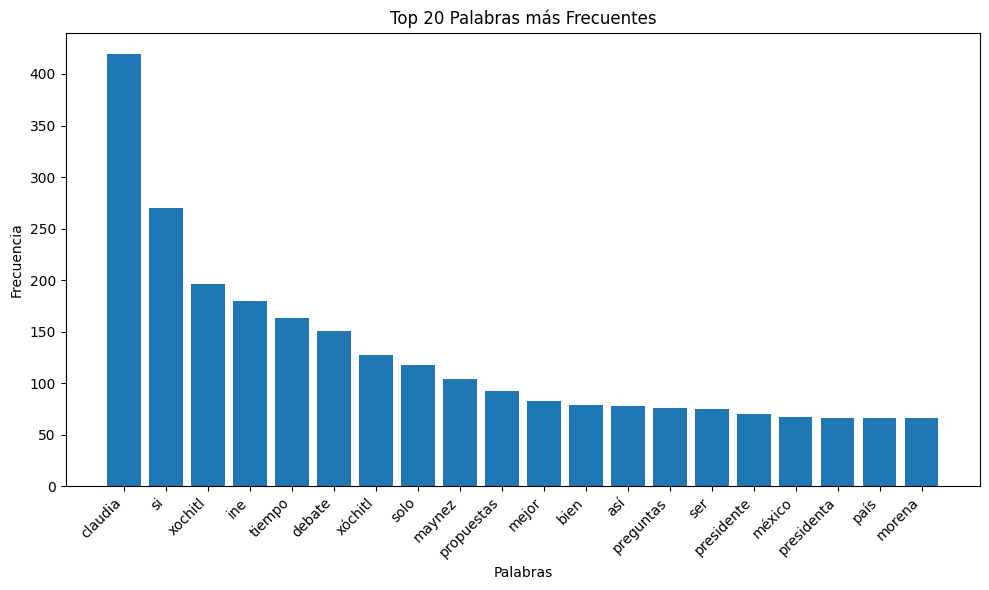

In [139]:
plt.figure(figsize=(10, 6))
plt.bar(df_frecuencias.iloc[:20].token, df_frecuencias.iloc[:20].conteo)

# Personaliza las etiquetas del eje X
plt.xticks(rotation=45, ha='right')  # Inclina los nombres de las palabras para mejorar la legibilidad

plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Top 20 Palabras más Frecuentes')
plt.tight_layout()
plt.show()

(-0.5, 399.5, 199.5, -0.5)

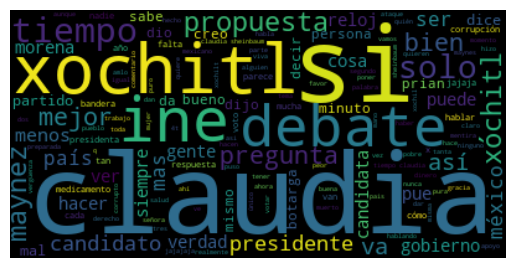

In [140]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(tokens))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")